# Análisis comparativo de algoritmos de clasificación para un problema de clasificación multietiqueta

## Programa principal clasificador

Este notebook contiene el código implementado que ha servido para la realización del Trabajo Fin de Máster del Máster Universitario de Telecomunicación, de la Universidad Carlos III de Madrid.

Este programa toma un dataset determinado dado, anonimizado, e implementa dos tipos de soluciones:
 - Soluciones de machine learning.
 - Soluciones de deep learning.

### Importado de librerías
Para ello, hace uso de numerosas librerías de Python, de las que cabe destacar **sklearn** y **keras**, al ser las librerías que implementan los algoritmos tanto de aprendizaje automático como profundo.

In [17]:
### IMPORTS ###
#Librerías generales
import scipy.sparse
import scipy.stats
import numpy as np
import time
import valores  #Contiene un script de Python con diccionarios de parámetros para realizar CV 
from pyemd import emd
#Módulos de sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
import sklearn.metrics as mtc
#Módulos de keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,GaussianNoise
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json

### Desarollo de la clase principal

El programa gira en torno a una clase desarrollada a continuación, la clase **TFM**, la cual se instanciará en el programa principal, y permite realizar, mediante métodos, la carga del dataset, el preprocesado de los datos, la ejecución de la solución y la impresión de métricas.

Los métodos que implementa dicha clase y sus funciones son las siguientes:

 - __init__ : realiza la carga del dataset, binariza las características para adaptarlas a los algoritmos a implementar, y aplica sobre los datos de entrenamiento y test un scaler, con el objetivo de obtener mejores prestaciones de clasificación.
 
 - __reduce_features__ : método que permite reducir el número de características del dataset, para obtener un conjunto de datos más manejable. Permite indicar qué número mínimo de muestras son necesarias por categoría para que esta sea conservada. El resultado de este proceso se guarda en un fichero de texto, para acceder a él cuando sea necesario.
 
 - __simplify_dataset__ : permite realizar una simplificación tanto a nivel de muestras como a nivel de características. A nivel de muestras elimina aleatoriamente un porcentaje indicado por el usuario, a nivel de categoría, se sirve de los ficheros de texto generados por el método anterior.
 
 - __grid_search_cv__ : este método realiza la validación cruzada para las soluciones de machine learning. Aplica cada uno de los clasificadores lineales implementados sobre OneVsRestClassifier o sobre ClassifierChain, lo cual es elegido por el usuario.
 
 - __fitting_classifier__ : se utiliza para realizar el entrenamiento del modelo, una vez realizado el ajuste de los parámetros mediante validación cruzada, para todo el conjunto de datos de entrenamiento, sin simplificar.
 
 - __pred_metr__ : realiza la clasificación, sobre los datos de test, una vez el algoritmo utilizado ya ha sido entrenado.
 
 - __metrics__ : método que calcula e imprime las distintas métricas de prestaciones implementadas.
 
 - __dnn__ : implementa el algoritmo de redes neuronales y lo entrena con el dataset de entrenamiento.
 
 - __multilabelconfussion__ : genera una matriz de confusión definida en exclusiva para el caso de clasificación multietiqueta.
 

In [18]:
## FUNCIONES ##


class TFM:

    def __init__(self,path):
        self.X_tr = scipy.sparse.load_npz(path+'X_tr.npz') 
        self.X_tst = scipy.sparse.load_npz(path+'X_tst.npz')
        self.y_tr = np.load(path+'y_tr.npy')
        self.y_tst = np.load(path+'y_tst.npy')
        # Se binarizan las caracteristicas
        self.Mlb=MultiLabelBinarizer().fit(self.y_tr)
        self.y_tr=self.Mlb.transform(self.y_tr)
        self.y_tst=self.Mlb.transform(self.y_tst)
        # Escalado 
        scaler = MaxAbsScaler().fit(self.X_tr)
        self.X_tr=scaler.transform(self.X_tr)
        self.X_tst=scaler.transform(self.X_tst)
        self.X_tr_simpli= None
        self.modelo = None
        self.clf= None
        self.columns= None
        print ('Dataset cargado y preprocesado')

    def reduce_features(self,num_data):
        columns=np.array([])
        for i in range(np.shape(self.X_tr)[1]):
            if self.X_tr[:,i].count_nonzero()> num_data:
                columns=np.append(columns,i)
        np.savetxt('./features/features'+num_data+'.txt',columns,delimiter=',')
        print('Las características han sido reducidas')

    def simplify_dataset(self,features,tr_size):
        self.X_tr_simpli=self.X_tr
        self.y_tr_simpli=self.y_tr
        self.columns=np.loadtxt('./features/features'+features+'.txt',delimiter=',')  #Carga los .txt generados por reduce_features
        self.X_tr_simpli=self.X_tr[:,self.columns]
        self.X_tr_simpli, __, self.y_tr_simpli, __ = train_test_split(self.X_tr_simpli, self.y_tr_simpli, test_size=(1-tr_size), random_state=42)
        print('Simplificación finalizada')
        
    def grid_search_cv(self,classifier,parameters,metodo):
        if (metodo == 0):
            classif = OneVsRestClassifier(classifier)
        elif (metodo==1):
            classif = ClassifierChain(classifier)
        model_tunning = GridSearchCV(classif, param_grid=parameters,cv=4,verbose=50, n_jobs=-1,scoring='accuracy')
        model_tunning.fit(self.X_tr_simpli, self.y_tr_simpli)
        print (model_tunning.best_score_) #Imprime el máximo scoring obtenido mediante CV
        print (model_tunning.best_params_) #Imprime los mejores parámetros obtenidos para el algoritmo
        self.modelo = model_tunning.best_estimator_

    def fitting_classifier(self):
        self.clf=self.modelo.fit(self.X_tr,self.y_tr)

    def pred_metr(self):
        self.y_pred=self.clf.predict(self.X_tst)
        self.metrics()
        
    def metrics(self):
        accuracy=mtc.accuracy_score(self.y_tst,self.y_pred)
        hamming=mtc.hamming_loss(self.y_tst,self.y_pred)
        precision=mtc.precision_score(self.y_tst,self.y_pred,average='micro')
        print("Total accuracy: ", accuracy)
        print("Hamming loss: ", hamming)
        aux=0
        for i in range(np.shape(self.y_pred)[1]):
            aux=aux+mtc.accuracy_score(self.y_tst[:,i],self.y_pred[:,i])
        print("Accuracy media: ",aux/37)
        distance_matrix=np.ones((37,37))*(1/37)  
        np.fill_diagonal(distance_matrix,0)
        emd_aux=0
        for i in range (np.shape(self.y_tst)[0]):
            emd_aux= emd_aux + emd(self.y_tst[i,:].astype(float),self.y_pred[i,:].astype(float),distance_matrix)
        print("EMD: ", emd_aux/(np.shape(self.y_tst)[0])) #La matriz distance_matrix permite variar cuánto importa equivocarse en unas etiquetas respecto de otras
        
    def dnn(self,batch,epochs):
        num_classes = 37
        batch_size = batch
        epochs = epochs
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 3) #Implementa EarlyStopping para detener el algoritmo si éste no mejorar sus prestaciones, en base al validation loss
        filepath1="./nn/weights.best.acc.hdf5"  
        filepath2="./nn/weights.best.loss.hdf5"
        checkpointacc = ModelCheckpoint(filepath1, monitor='val_acc', verbose=1, save_best_only=True, mode='max') #Guarda la información de los pesos del modelo que obtuvo un mejor accuracy de validación
        checkpointloss = ModelCheckpoint(filepath2, monitor='val_loss', verbose=1, save_best_only=True, mode='min') #Guarda la información de los pesos del modelo que obtuvo un mejor loss de validación
        callbacks_list = [checkpointacc,checkpointloss,es]
        self.model = Sequential() #Genera un modelo secuencial y añade las distintas capas de neuronas
        input_shape=(np.shape(self.X_tr)[1],)
        self.model.add(Dense(200, activation='relu',input_shape=input_shape))
        self.model.add(Dropout(0.3))
        #self.model.add(GaussianNoise(0.1))
        self.model.add(Dense(200, activation='relu'))
        self.model.add(Dropout(0.3))
        #self.model.add(GaussianNoise(0.1))
        self.model.add(Dense(200, activation='relu'))
        self.model.add(Dropout(0.3))
        #self.model.add(GaussianNoise(0.1))
        self.model.add(Dense(200, activation='relu'))
        self.model.add(Dropout(0.3))
        #self.model.add(GaussianNoise(0.1))
        self.model.add(Dense(num_classes, activation='sigmoid'))
        print(self.model.summary())
        self.model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
        #self.model.load_weights("./nn/weights.best.acc.hdf5") #Para cargar los pesos guardados de un modelo
        hist = self.model.fit(self.X_tr, self.y_tr,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(self.X_tst, self.y_tst),callbacks=callbacks_list) #Entrenamiento de la red neuronal, equiparable a la carga de pesos del modelo
        self.y_pred = self.model.predict(self.X_tst) #Predicción en base al dataset de test
        self.y_pred[self.y_pred>=0.5] = 1  #Se genera la frontera de decisión
        self.y_pred[self.y_pred<0.5] = 0
        self.metrics()

    
    def multilabelconfussion(self):  
        self.testlabels=self.Mlb.inverse_transform(self.y_tst)
        self.predlabels=self.Mlb.inverse_transform(self.y_pred)
        cm=np.zeros((38,38))
        for pos1,i in enumerate(self.testlabels):
            auxlist1=list(self.testlabels[pos1])
            auxlist2=list(self.predlabels[pos1])
            for pos2,j in enumerate(self.testlabels[pos1]):
                if j in list(self.predlabels[pos1]):
                    cm[j,j]=cm[j,j]+1
                    auxlist1.remove(j)
                    auxlist2.remove(j)
            if not auxlist1:
                if not auxlist2:
                    continue
                else:
                    for pos2,j in enumerate(auxlist2):
                        cm[37,j]=cm[37,j]+1/len(auxlist2)
            else:
                if not auxlist2:
                    for pos2,j in enumerate(auxlist1):
                        cm[j,37]=cm[j,37]+1
                else:
                    for pos2,j in enumerate(auxlist1):
                        for pos3,k in enumerate(auxlist2):
                            cm[j,k]=cm[j,k]+1/len(auxlist2)
        return cm
    
#Esta función está disponible en la documentación de scikit-learn: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#Imprime una matriz de confusión
    def plot_confusion_matrix(self,
                              target_names,
                              title='Matriz de confusión',
                              cmap=None,
                              normalize=True):
        """
        given a sklearn confusion matrix (cm), make a nice plot

        Arguments
        ---------
        cm:           confusion matrix from sklearn.metrics.confusion_matrix

        target_names: given classification classes such as [0, 1, 2]
                      the class names, for example: ['high', 'medium', 'low']

        title:        the text to display at the top of the matrix

        cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                      see http://matplotlib.org/examples/color/colormaps_reference.html
                      plt.get_cmap('jet') or plt.cm.Blues

        normalize:    If False, plot the raw numbers
                      If True, plot the proportions

        Usage
        -----
        plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                                  # sklearn.metrics.confusion_matrix
                              normalize    = True,                # show proportions
                              target_names = y_labels_vals,       # list of names of the classes
                              title        = best_estimator_name) # title of graph


        """
        import matplotlib.pyplot as plt
        import numpy as np
        import itertools
        if cmap is None:
            cmap = plt.get_cmap('Blues')

        plt.figure(figsize=(40,30))
        plt.imshow(self.cm, interpolation='nearest', cmap=cmap)
        plt.title(title,fontsize=50)
        plt.colorbar()

        if target_names is not None:
            tick_marks = np.arange(len(target_names))
            plt.xticks(tick_marks, target_names, rotation=45,fontsize=25)
            plt.yticks(tick_marks, target_names,fontsize=25)

        if normalize:
            cm = self.cm.astype('float') / self.cm.sum(axis=1)[:, np.newaxis]


        thresh = self.cm.max() / 1.5 if normalize else self.cm.max() / 2
        for i, j in itertools.product(range(self.cm.shape[0]), range(self.cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(self.cm[i, j]),
                         horizontalalignment="center",
                         color="white" if self.cm[i, j] > thresh else "black",fontsize=17)
            else:
                plt.text(j, i, "{:0.2f}".format(self.cm[i, j]),
                         horizontalalignment="center",
                         color="white" if self.cm[i, j] > thresh else "black",fontsize=17)


        plt.tight_layout()
        plt.ylabel('Etiquetas verdaderas',fontsize=35)
        plt.xlabel('Etiquetas clasificadas',fontsize=35)
        plt.show()

### Desarollo del programa principal

Una vez definida la clase **TFM**, se pasa a desarrollar el programa principal, el cual permitirá al usuario realizar lo siguiente:
 - Elegir si quiere utilizar un clasificador lineal (machine learning) o redes neuronales (deep learning).
 - Si elige un clasificador lineal:
     - Permite elegir el clasificador lineal a implementar.
     - Permite elegir el clasificador multietiqueta a utilizar (OneVsRestClassifier o ClassifierChain).
     - Permite realizar la simplificación del dataset, en base a muestras y características.
     - Ejecuta validación cruzada.
     - Entrena, predice e imprime las métricas solución.
 - Si elige redes neuronales:
     - Implementa el algoritmo de redes neuronales, decidiendo el batch size y el número de épocas para el entrenamiento.
     - Entrena, predice e imprime las métricas solución.

In [19]:
path='../../Datasets/dataset/' #Path donde se encuentra el dataset de entrenamiento y test, introducirlo en el siguiente input
path_string=input('Introduce el directorio del dataset')
clasificacion=TFM(path_string)
print('Inicio del programa clasificador')

while True:
    clasi_mode=int(input('Vas a usar clasificación lineal (0) o redes neuronales (1):'))
    if (clasi_mode==0): 
        clasi_type=int(input('Que clasificador vas a usar?\nPuedes elegir entre LogisticRegression (0), SGD (1), Perceptron (2) o PassiveAggresiveClassifier (3):  '))
        clasificador=valores.clasificadores_dict[clasi_type]
        metod=int(input('Que metodo vas a usar, ¿OneVsRestClassifier (0), o ClassifierChain(1)?'))
        non_zero_data=input(('Introduce el numero de elementos no nulos por categoria que consideras aceptable, de entre los siguientes :\n250, 500, 1000, 3000, 10000 '))
        training_size=float(input('Introduce el porcentaje de tamano de datos de entrenamiento que quieres usar para simplificar, en tanto por uno: '))
        print('Realizando simplificacion del dataset...')
        clasificacion.simplify_dataset(non_zero_data,training_size)
        print("Iniciando tunning de los parámetros...")
        clasificacion.grid_search_cv(clasificador,valores.parametros_dict[(clasificador,metod)],metod)    
        print("¡Tunning finalizado!")  
        print("Entrenando el algoritmo con los mejores parametros...")
        clasificacion.fitting_classifier()
        print("Entrenamiento finalizado, se procede a predecir las etiquetas")
        print("Mostrando metricas obtenidas")
        clasificacion.pred_metr()
        change_classi=input('Quieres probar con otro clasificador (si) o finalizamos el programa (no)?: ')
        if (change_classi.lower()=='si'):
            continue
        elif (change_classi.lower()=='no'):
            break
    elif (clasi_mode==1):
        batch =int(input('Introduce el batch size: '))
        epochs =int(input('Introduce el numero de epocas: '))
        clasificacion.dnn(batch,epochs)
        change_classi = input('Quieres probar con otro clasificador (si) o finalizamos el programa (no)?: ')
        if (change_classi.lower()=='si'):
            continue
        elif (change_classi.lower() =='no'):
            break    
        
print("Fin del programa clasificador")



Introduce el directorio del dataset../../Datasets/dataset/
Dataset cargado y preprocesado
Inicio del programa clasificador
Vas a usar clasificación lineal (0) o redes neuronales (1):1
Introduce el batch size: 128
Introduce el numero de epocas: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 200)               8901600   
_________________________________________________________________
dropout_17 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 200)               40200     
___________________________

### Matriz de confusión

A continuación, se mostrará la matriz de confusión diseñada para la solución obtenida del programa principal, con el fin de observar la disposición de los errores y aciertos cometidos de manera gráfica.

Mostrando matriz de confusión: 


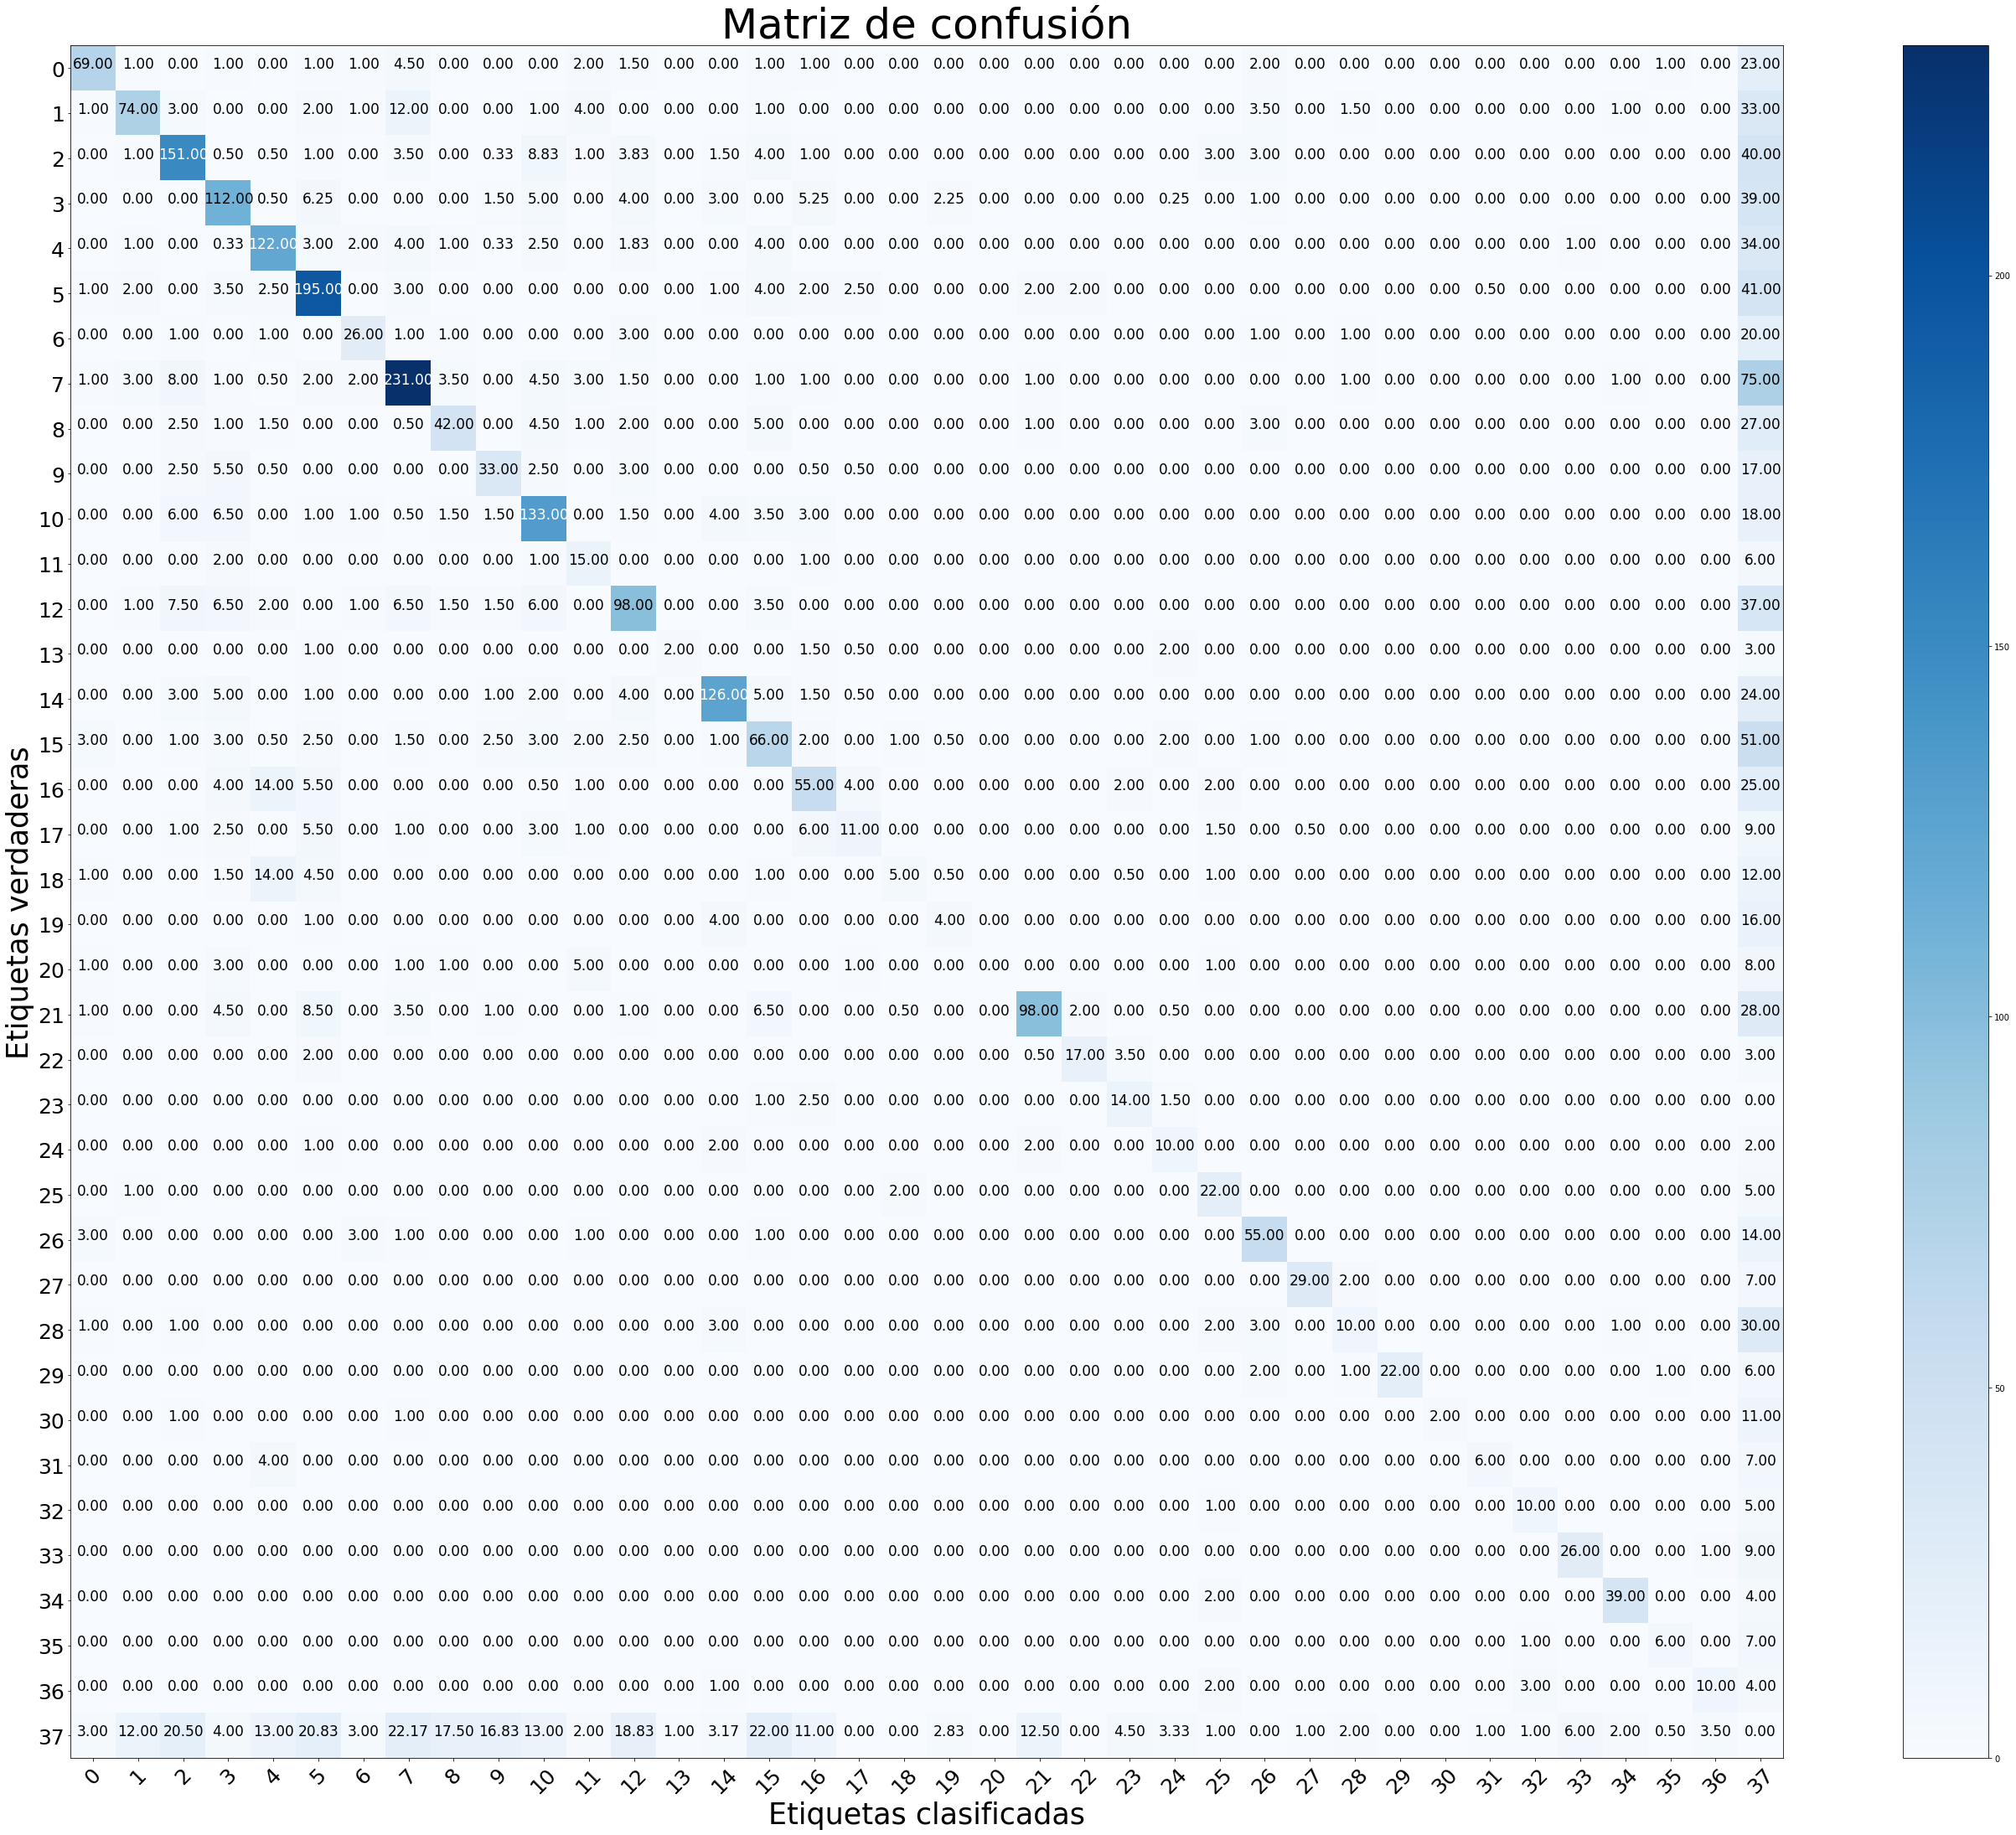

In [20]:
print("Mostrando matriz de confusión: ")
clasificacion.cm=clasificacion.multilabelconfussion()
clasificacion.plot_confusion_matrix(list(range(38)),normalize=False)